In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [2]:
with open('low_var_port.pkl', 'rb') as f: d = pickle.load(f)

# Allocate shares

In [4]:
'''
Distributes shares among a portfolio based on initial price, money and portfolio weights of the stock
Inputs:
    1) data - Dataframe of assets with price multiindexed column names with the highest level being the tickers and the next level
    being prc | ret | retx | retd.
    2) initial_money - Initial money to be used to purchase assets
    3) portfolio_weights - Dictionary of {tickers : weight or asset} e.g. {'spy':0.5, 'tlt': 0.4, "gld": 0.1}
'''

def allocate_shares(data, portfolio_weights,initial_money = 10000000):
    latest_prices = {}
    date_start = data.index[0].date().isoformat()
    for k in portfolio_weights.keys():
        latest_prices[k] = data.loc[date_start][k]['prc']
        srs_latest_prices = pd.Series(latest_prices)
        
    da = DiscreteAllocation(portfolio_weights, srs_latest_prices, total_portfolio_value=initial_money)
    shares, cash = da.lp_portfolio()
    return shares, cash, srs_latest_prices, date_start

In [9]:
portfolio_weights = {'SPY':.5, 'TLT': .4, 'GLD': .1}
shares, cash, latest_prices, date_start = allocate_shares(d, portfolio_weights, initial_money = 10000000)


In [6]:
latest_prices

SPY    117.419998
TLT     88.260002
GLD     44.779999
dtype: float64

In [7]:
date_start = d.index[0].date().isoformat()
portfolio_weights = {'spy':0.5, 'tlt': 0.4, "gld": 0.1}
latest_prices = {'spy': d.loc[date_start]['SPY']['prc'], 'tlt': d.loc[date_start]['TLT']['prc'], \
          'gld': d.loc[date_start]['GLD']['prc']}
latest_prices = pd.Series(latest_prices)

da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=10000000)
shares, cash = da.lp_portfolio()

In [10]:
allocate_shares(d, portfolio_weights,initial_money=100000)[2].index

Index(['SPY', 'TLT', 'GLD'], dtype='object')

# Set up dataframe to track trades

In [14]:
'''
Initializes dataframes used for rebalancing.
Inputs:
    1) shares - dictionary of the quantity of each share.
    2) cash - Money leftover or in cash reserves
    3) latest_prices - The prices on the first day
'''

def initialize_df(data, portfolio_weights,initial_money=1000000):
    shares, cash, srs_latest_prices, date_start = allocate_shares(data, portfolio_weights,initial_money)
    ls_trades = []
    ls_tickers = []
    ls_labels = ['shr chg', 'prc', 'csh chg', 'tot shr', 'tot bal', 'divflag', 'rebalflag']
    for k in srs_latest_prices.index:
        ls_trades = ls_trades + [shares[k], srs_latest_prices[k], -shares[k]*srs_latest_prices[k], shares[k], shares[k]*srs_latest_prices[k],0, 0]
        ls_tickers.append(k)
    ls_trades_iterables = [ls_tickers, ls_labels]
    trades_columns = pd.MultiIndex.from_product(ls_trades_iterables, names=['ticker', 'metric'])
    df_trades_initial = pd.DataFrame(np.array([ls_trades]),columns=trades_columns, index = [date_start])
    
    #Initialize df_cash dataframe
    df_cash_initial = pd.DataFrame(cash, columns = ['cash'], index = [date_start])
    
    #Initialize df_portfolio_detail dataframe
    ls_port_det_int_labels = ['price', 'return', 'weight', 'shares', 'value']
    ls_port_det_int_iterables = [ls_tickers, ls_port_det_int_labels]
    columns = pd.MultiIndex.from_product(ls_port_det_int_iterables, names=['ticker', 'metric'])
    df_portfolio_detail_initial = pd.DataFrame(columns=columns)

    #Initialize df_portfolio_sum dataframe
    ls_port_sum_labels = ['total_value', 'asset_value', 'cash', 'cash_pct']
    df_portfolio_sum_initial = pd.DataFrame(columns=ls_port_sum_labels)



    return df_trades_initial, df_cash_initial, df_portfolio_sum_initial, df_portfolio_detail_initial

In [13]:
shares, cash, srs_latest_prices, date_start = allocate_shares(d, portfolio_weights,initial_money=100000)
ls_trades = []
ls_tickers = []
ls_labels = ['shr chg', 'prc', 'csh chg', 'tot shr', 'tot bal', 'divflag', 'rebalflag']
for k in srs_latest_prices.index:
    ls_trades = ls_trades + [shares[k], srs_latest_prices[k], -shares[k]*srs_latest_prices[k], shares[k], shares[k]*srs_latest_prices[k],0, 0]
    ls_tickers.append(k)
ls_trades_iterables = [ls_tickers, ls_labels]
trades_columns = pd.MultiIndex.from_product(ls_trades_iterables, names=['ticker', 'metric'])
df_trades_initial = pd.DataFrame(np.array([ls_trades]),columns=trades_columns, index = [date_start])

#Initialize df_cash dataframe
df_cash_initial = pd.DataFrame(cash, columns = ['cash'], index = [date_start])

#Initialize df_portfolio_detail dataframe
ls_port_det_int_labels = ['price', 'return', 'weight', 'shares', 'value']
ls_port_det_int_iterables = [ls_tickers, ls_port_det_int_labels]
columns = pd.MultiIndex.from_product(ls_port_det_int_iterables, names=['ticker', 'metric'])
df_portfolio_detail_initial = pd.DataFrame(columns=columns)

#Initialize df_portfolio_sum dataframe
ls_port_sum_labels = ['total_value', 'asset_value', 'cash', 'cash_pct']
df_portfolio_sum_initial = pd.DataFrame(columns=ls_port_sum_labels)

In [15]:
df_trades_initial, df_cash_initial, df_portfolio_sum_initial, df_portfolio_detail_initial = initialize_df(d, portfolio_weights,initial_money=10000000000)

# Dataframe to track daily movements

In [73]:
iterables = [['SPY', 'TLT', 'GLD'], ['price', 'return', 'weight', 'shares', 'value']]
columns = pd.MultiIndex.from_product(iterables, names=['ticker', 'metric'])
date = []
portfolio_detail_initial = pd.DataFrame(columns=columns)

In [27]:
df_trades_initial, df_cash_initial, df_portfolio_sum_initial, df_portfolio_detail_initial = initialize_df(d, portfolio_weights,initial_money=1000000)

In [75]:
columns = ['total_value', 'asset_value', 'cash', 'cash_pct']


portfolio_sum_initial = pd.DataFrame(columns=columns)

# Loop to track dividend payments and rebalance every 6 months

In [65]:


rebalance_days = 63
trading_day_counter = 1
df_trades = df_trades_initial
portfolio_detail = df_portfolio_detail_initial
portfolio_sum = df_portfolio_sum_initial
df_cash = df_cash_initial
yesterday_prices =  {'SPY': d.loc[date_start]['SPY']['prc'], 'TLT': d.loc[date_start]['TLT']['prc'], \
          'GLD': d.loc[date_start]['GLD']['prc']}
portfolio_weights = {'SPY':0.5, 'TLT': 0.4, "GLD": 0.1}
#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

for index, row in d.iterrows():
    tradeflag = 0
    s_divflag, t_divflag, g_divflag = (0,0,0)
    tlt_div_cash = 0
    spy_div_cash = 0
    gld_div_cash = 0
    rebal_spy = 0
    rebal_tlt = 0
    rebal_gld = 0
    leftover_cash = 0
    latest_prices = {'SPY': row['SPY']['prc'], 'TLT': row['TLT']['prc'], \
          'GLD': row['GLD']['prc']}
    new_spy_shares = 0
    new_gld_shares = 0
    new_tlt_shares = 0
    
    
    #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend
    
    if row['SPY']['retd'] > 0:
        s_divflag=1
        spy_div_cash = yesterday_prices['SPY']*df_trades['SPY']['tot shr'].iloc[-1]*row['SPY']['retd']
        new_spy_shares = int(spy_div_cash/latest_prices['SPY'])
        leftover_cash = spy_div_cash-(new_spy_shares*latest_prices['SPY'])
        
    if row['TLT']['retd'] > 0:
        t_divflag = 1
        tlt_div_cash = yesterday_prices['TLT']*df_trades['TLT']['tot shr'].iloc[-1]*row['TLT']['retd']
        new_tlt_shares = int(tlt_div_cash/latest_prices['TLT'])
        leftover_cash = tlt_div_cash-(new_tlt_shares*latest_prices['TLT'])+leftover_cash
    
    if row['GLD']['retd'] > 0:
        g_divflag=1
        gld_div_cash = yesterday_prices['GLD']*df_trades['GLD']['tot shr'].iloc[-1]*row['GLD']['retd']
        new_gld_shares = int(gld_div_cash/latest_prices['GLD'])
        leftover_cash = gld_div_cash-(new_gld_shares*latest_prices['GLD'])+leftover_cash

    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.
    
    if 1 in [s_divflag, t_divflag, g_divflag]:
        div_trade_add = pd.DataFrame([[new_spy_shares, latest_prices['SPY'], -new_spy_shares * latest_prices['SPY'],df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares, (df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares)*latest_prices['SPY'], s_divflag, tradeflag,
                        new_tlt_shares, latest_prices['TLT'], -new_tlt_shares * latest_prices['TLT'],df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares, (df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares)*latest_prices['TLT'], t_divflag, tradeflag,
                        new_gld_shares, latest_prices['GLD'], -new_gld_shares * latest_prices['GLD'],df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares, (df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares)*latest_prices['GLD'], g_divflag, tradeflag]], index = [index], columns = df_trades.columns) 
        df_trades = df_trades.append(div_trade_add)
        df_cash = df_cash.append(pd.DataFrame(df_cash['cash'].iloc[-1]+leftover_cash,columns = ['cash'], 
                         index = [row.name]))
        divflag=0
    
    #Checks to see if rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
    #and reblances using the original weights and the total value available. The share amount before rebalancing is then
    #subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.
    
    if trading_day_counter % rebalance_days == 0:
        tradeflag = 1
        latest_prices = pd.Series(latest_prices)
        cur_shrs = np.array([df_trades['SPY']['tot shr'].iloc[-1], df_trades['TLT']['tot shr'].iloc[-1],df_trades['GLD']['tot shr'].iloc[-1]])
        total_money = np.matmul(np.array(latest_prices),cur_shrs)+df_cash['cash'].iloc[-1]
        
        
        da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=total_money)
        shares, cash = da.greedy_portfolio()
        rebal_spy = shares['SPY']-df_trades['SPY']['tot shr'].iloc[-1]
        rebal_tlt = shares['TLT']-df_trades['TLT']['tot shr'].iloc[-1]
        rebal_gld = shares['GLD']-df_trades['GLD']['tot shr'].iloc[-1]
        trade_add = pd.DataFrame([[rebal_spy, latest_prices['SPY'], -rebal_spy*latest_prices['SPY'],shares['SPY'], shares['SPY']*latest_prices['SPY'], divflag, tradeflag,
                        rebal_tlt, latest_prices['TLT'], -rebal_tlt*latest_prices['TLT'], shares['TLT'], shares['TLT']*latest_prices['TLT'], divflag, tradeflag,
                        rebal_gld, latest_prices['GLD'], -rebal_gld*latest_prices['GLD'], shares['GLD'], shares['GLD']*latest_prices['GLD'], divflag, tradeflag]], 
                        index = [index], columns = df_trades.columns)
        df_trades = df_trades.append(trade_add)
        df_cash = df_cash.append(pd.DataFrame(cash,columns = ['cash'],index = [row.name]))
        trading_day_counter=1
    else:
        trading_day_counter += 1
    yesterday_prices = latest_prices    
        
    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    
    share_dic = {'SPY':df_trades['SPY']['tot shr'].iloc[-1],
                 'TLT':df_trades['TLT']['tot shr'].iloc[-1],
                 'GLD':df_trades['GLD']['tot shr'].iloc[-1]}
    
    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}
    
    new_port_det = np.array([[latest_prices['SPY'], row["SPY"]['ret'], actual_weights["SPY"], share_dic['SPY'], tic_vals['SPY'],
                    latest_prices['TLT'], row["TLT"]['ret'], actual_weights["TLT"], share_dic['TLT'], tic_vals['TLT'],
                    latest_prices['GLD'], row["GLD"]['ret'], actual_weights["GLD"], share_dic['GLD'], tic_vals['GLD']]])
    portfolio_detail = portfolio_detail.append(pd.DataFrame(new_port_det,columns = portfolio_detail.columns))
    
    new_port_sum = np.array([[total_value+df_cash.iloc[-1][0], total_value, df_cash.iloc[-1][0], df_cash.iloc[-1][0]/(total_value+df_cash.iloc[-1][0])]])
    
    portfolio_sum = portfolio_sum.append(pd.DataFrame(new_port_sum, columns = portfolio_sum.columns))

portfolio_detail.index = d.index
portfolio_sum.index = d.index

In [69]:
threshold = .1
df_trades = df_trades_initial
df_cash = df_cash_initial

portfolio_detail = df_portfolio_detail_initial
portfolio_sum = df_portfolio_sum_initial
yesterday_prices =  {'SPY': d.loc[date_start]['SPY']['prc'], 'TLT': d.loc[date_start]['TLT']['prc'], \
          'GLD': d.loc[date_start]['GLD']['prc']}

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

for index, row in d.iterrows():
    tradeflag = 0
    s_divflag, t_divflag, g_divflag = (0,0,0)
    tlt_div_cash = 0
    spy_div_cash = 0
    gld_div_cash = 0
    rebal_spy = 0
    rebal_tlt = 0
    rebal_gld = 0
    leftover_cash = 0
    
    latest_prices = {'SPY': row['SPY']['prc'], 'TLT': row['TLT']['prc'], \
          'GLD': row['GLD']['prc']}
    new_spy_shares = 0
    new_gld_shares = 0
    new_tlt_shares = 0
    
        #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend
    
    if row['SPY']['retd'] > 0:
        s_divflag=1
        spy_div_cash = yesterday_prices['SPY']*df_trades['SPY']['tot shr'].iloc[-1]*row['SPY']['retd']
        new_spy_shares = int(spy_div_cash/latest_prices['SPY'])
        leftover_cash = spy_div_cash-(new_spy_shares*latest_prices['SPY'])
        
    if row['TLT']['retd'] > 0:
        t_divflag = 1
        tlt_div_cash = yesterday_prices['TLT']*df_trades['TLT']['tot shr'].iloc[-1]*row['TLT']['retd']
        new_tlt_shares = int(tlt_div_cash/latest_prices['TLT'])
        leftover_cash = tlt_div_cash-(new_tlt_shares*latest_prices['TLT'])+leftover_cash
    
    if row['GLD']['retd'] > 0:
        g_divflag=1
        gld_div_cash = yesterday_prices['GLD']*df_trades['GLD']['tot shr'].iloc[-1]*row['GLD']['retd']
        new_gld_shares = int(gld_div_cash/latest_prices['GLD'])
        leftover_cash = gld_div_cash-(new_gld_shares*latest_prices['GLD'])+leftover_cash

    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.
    
    if 1 in [s_divflag, t_divflag, g_divflag]:
        div_trade_add = pd.DataFrame([[new_spy_shares, latest_prices['SPY'], -new_spy_shares * latest_prices['SPY'],df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares, (df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares)*latest_prices['SPY'], s_divflag, tradeflag,
                        new_tlt_shares, latest_prices['TLT'], -new_tlt_shares * latest_prices['TLT'],df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares, (df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares)*latest_prices['TLT'], t_divflag, tradeflag,
                        new_gld_shares, latest_prices['GLD'], -new_gld_shares * latest_prices['GLD'],df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares, (df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares)*latest_prices['GLD'], g_divflag, tradeflag]], index = [index], columns = df_trades.columns) 
        df_trades = df_trades.append(div_trade_add)
        df_cash = df_cash.append(pd.DataFrame(df_cash['cash'].iloc[-1]+leftover_cash,columns = ['cash'], 
                         index = [row.name]))
        divflag=0
    
    
    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}
    dev_weights = {k:abs((actual_weights[k]/portfolio_weights[k])-1) for k in actual_weights}
    
    #Checks to see if rebalancing should occur due to an asset passing the threshold. The % deviation is calculated by: 
    #
    #                       |[Actual % of portfolio] / [target % of portfolio] - 1|
    #
    #If this absolute value is greater than the threshold, rebalancing occurs. This sells all the shares and reblances 
    #using the original weights and the total value available. The share amount before rebalancing is then subtracted 
    #to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.
    
    if max(dev_weights[k] for k in actual_weights) > threshold:
        tradeflag = 1
        latest_prices = pd.Series(latest_prices)
        cur_shrs = np.array([df_trades['SPY']['tot shr'].iloc[-1], df_trades['TLT']['tot shr'].iloc[-1],df_trades['GLD']['tot shr'].iloc[-1]])
        total_money = np.matmul(np.array(latest_prices),cur_shrs)+df_cash['cash'].iloc[-1]
        
        
        da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=total_money)
        shares, cash = da.greedy_portfolio()
        rebal_spy = shares['SPY']-df_trades['SPY']['tot shr'].iloc[-1]
        rebal_tlt = shares['TLT']-df_trades['TLT']['tot shr'].iloc[-1]
        rebal_gld = shares['GLD']-df_trades['GLD']['tot shr'].iloc[-1]
        trade_add = pd.DataFrame([[rebal_spy, latest_prices['SPY'], -rebal_spy*latest_prices['SPY'],shares['SPY'], shares['SPY']*latest_prices['SPY'], divflag, tradeflag,
                        rebal_tlt, latest_prices['TLT'], -rebal_tlt*latest_prices['TLT'], shares['TLT'], shares['TLT']*latest_prices['TLT'], divflag, tradeflag,
                        rebal_gld, latest_prices['GLD'], -rebal_gld*latest_prices['GLD'], shares['GLD'], shares['GLD']*latest_prices['GLD'], divflag, tradeflag]], 
                        index = [index], columns = df_trades.columns)
        df_trades = df_trades.append(trade_add)
        df_cash = df_cash.append(pd.DataFrame(cash,columns = ['cash'],index = [row.name]))
        trading_day_counter=1
    else:
        trading_day_counter += 1
        yesterday_prices = latest_prices 
    
    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    
    share_dic = {'SPY':df_trades['SPY']['tot shr'].iloc[-1],
                 'TLT':df_trades['TLT']['tot shr'].iloc[-1],
                 'GLD':df_trades['GLD']['tot shr'].iloc[-1]}
    
    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}
    
    new_port_det = np.array([[latest_prices['SPY'], row["SPY"]['ret'], actual_weights["SPY"], share_dic['SPY'], tic_vals['SPY'],
                    latest_prices['TLT'], row["TLT"]['ret'], actual_weights["TLT"], share_dic['TLT'], tic_vals['TLT'],
                    latest_prices['GLD'], row["GLD"]['ret'], actual_weights["GLD"], share_dic['GLD'], tic_vals['GLD']]])
    portfolio_detail = portfolio_detail.append(pd.DataFrame(new_port_det,columns = portfolio_detail.columns))
    
    new_port_sum = np.array([[total_value+df_cash.iloc[-1][0], total_value, df_cash.iloc[-1][0], df_cash.iloc[-1][0]/(total_value+df_cash.iloc[-1][0])]])
    
    portfolio_sum = portfolio_sum.append(pd.DataFrame(new_port_sum, columns = portfolio_sum.columns))

portfolio_detail.index = d.index
portfolio_sum.index = d.index

In [14]:
portfolio_detail

ticker             SPY                                                    TLT  \
metric           price    return    weight   shares         value       price   
date                                                                            
2004-11-19  117.419998  0.988883  0.499998  42582.0  4.999978e+06   88.260002   
2004-11-22  117.980003  1.004769  0.499959  42582.0  5.023825e+06   88.720001   
2004-11-23  118.160004  1.001526  0.500314  42582.0  5.031489e+06   88.830002   
2004-11-24  118.440002  1.002370  0.500572  42582.0  5.043412e+06   88.830002   
2004-11-26  118.339996  0.999156  0.501403  42582.0  5.039154e+06   88.250000   
...                ...       ...       ...      ...           ...         ...   
2020-11-23  357.459991  1.005994  0.499999  58815.0  2.102401e+07  160.770004   
2020-11-24  363.220001  1.016114  0.506767  58815.0  2.136278e+07  159.169998   
2020-11-25  362.660004  0.998458  0.507022  58815.0  2.132985e+07  158.679993   
2020-11-27  363.670013  1.002785  0.506285  58815.0  2.138925e+07  160.220001   
2020-11-30  362.059998  0.995573  0.505756  58815.0  2.129456e+07  160.020004   

ticker                                                         GLD            \
metric        return    weight    shares         value       price    return   
date                                                                           
2004-11-19  0.992020  0.400003   45321.0  4.000032e+06   44.779999  1.009013   
2004-11-22  1.005212  0.400148   45321.0  4.020879e+06   44.950001  1.003796   
2004-11-23  1.001240  0.400318   45321.0  4.025865e+06   44.750000  0.995551   
2004-11-24  1.000000  0.399578   45321.0  4.025865e+06   45.049999  1.006704   
2004-11-26  0.993471  0.397964   45321.0  3.999578e+06   45.290001  1.005327   
...              ...       ...       ...           ...         ...       ...   
2020-11-23  0.995418  0.400001  104617.0  1.681928e+07  172.229996  0.980306   
2020-11-24  0.990048  0.395015  104617.0  1.665189e+07  169.589996  0.984672   
2020-11-25  0.996921  0.394606  104617.0  1.660062e+07  169.509995  0.999528   
2020-11-27  1.009705  0.396752  104617.0  1.676174e+07  167.789993  0.989853   
2020-11-30  0.998752  0.397602  104617.0  1.674081e+07  166.669998  0.993325   

ticker                                       
metric        weight   shares         value  
date                                         
2004-11-19  0.099998  22331.0  9.999822e+05  
2004-11-22  0.099894  22331.0  1.003778e+06  
2004-11-23  0.099368  22331.0  9.993122e+05  
2004-11-24  0.099849  22331.0  1.006012e+06  
2004-11-26  0.100633  22331.0  1.011371e+06  
...              ...      ...           ...  
2020-11-23  0.100000  24414.0  4.204823e+06  
2020-11-24  0.098218  24414.0  4.140370e+06  
2020-11-25  0.098372  24414.0  4.138417e+06  
2020-11-27  0.096963  24414.0  4.096425e+06  
2020-11-30  0.096643  24414.0  4.069081e+06  

[4035 rows x 15 columns]

In [15]:
portfolio_sum

,total_value,asset_value,cash,cash_pct
date,,,,
2004-11-19,1.000000e+07,9.999992e+06,7.928413,7.928413e-07
2004-11-22,1.004849e+07,1.004848e+07,7.928413,7.890154e-07
2004-11-23,1.005667e+07,1.005667e+07,7.928413,7.883733e-07
2004-11-24,1.007530e+07,1.007529e+07,7.928413,7.869162e-07
2004-11-26,1.005011e+07,1.005010e+07,7.928413,7.888881e-07
...,...,...,...,...
2020-11-23,4.204821e+07,4.204811e+07,97.478646,2.318259e-06
2020-11-24,4.215514e+07,4.215504e+07,97.478646,2.312379e-06
2020-11-25,4.206899e+07,4.206889e+07,97.478646,2.317114e-06


In [16]:
df_trades

ticker                   SPY                                                   \
metric               shr chg         prc       csh chg  tot shr       tot bal   
2004-11-19           42582.0  117.419998 -4.999978e+06  42582.0  4.999978e+06   
2004-11-19 00:00:00      0.0  117.419998 -0.000000e+00  42582.0  4.999978e+06   
2004-12-01 00:00:00      0.0  119.230003  0.000000e+00  42582.0  5.077052e+06   
2004-12-17 00:00:00    200.0  119.440002 -2.388800e+04  42782.0  5.109882e+06   
2004-12-31 00:00:00      0.0  120.870003  0.000000e+00  42782.0  5.171060e+06   
...                      ...         ...           ...      ...           ...   
2020-09-01 00:00:00      0.0  352.600006  0.000000e+00  62698.0  2.210732e+07   
2020-09-18 00:00:00    250.0  330.649994 -8.266250e+04  62948.0  2.081376e+07   
2020-10-01 00:00:00      0.0  337.040009  0.000000e+00  62948.0  2.121599e+07   
2020-11-02 00:00:00      0.0  330.200012  0.000000e+00  62948.0  2.078543e+07   
2020-11-23 00:00:00  -4133.0  357.459991  1.477382e+06  58815.0  2.102401e+07   

ticker                                     TLT                            ...  \
metric              divflag rebalflag  shr chg         prc       csh chg  ...   
2004-11-19              0.0       0.0  45321.0   88.260002 -4.000032e+06  ...   
2004-11-19 00:00:00     0.0       1.0      0.0   88.260002 -0.000000e+00  ...   
2004-12-01 00:00:00     1.0       0.0    184.0   86.449997 -1.590680e+04  ...   
2004-12-17 00:00:00     1.0       0.0      0.0   88.750000  0.000000e+00  ...   
2004-12-31 00:00:00     1.0       0.0    172.0   88.550003 -1.523060e+04  ...   
...                     ...       ...      ...         ...           ...  ...   
2020-09-01 00:00:00     1.0       0.0    110.0  163.860001 -1.802460e+04  ...   
2020-09-18 00:00:00     1.0       0.0      0.0  163.570007  0.000000e+00  ...   
2020-10-01 00:00:00     1.0       0.0    101.0  163.360001 -1.649936e+04  ...   
2020-11-02 00:00:00     1.0       0.0    105.0  158.580002 -1.665090e+04  ...   
2020-11-23 00:00:00     0.0       1.0   6352.0  160.770004 -1.021211e+06  ...   

ticker                                                   GLD              \
metric                    tot bal divflag rebalflag  shr chg         prc   
2004-11-19           4.000032e+06     0.0       0.0  22331.0   44.779999   
2004-11-19 00:00:00  4.000032e+06     0.0       1.0      0.0   44.779999   
2004-12-01 00:00:00  3.933907e+06     1.0       0.0      0.0   45.380001   
2004-12-17 00:00:00  4.038569e+06     1.0       0.0      0.0   44.189999   
2004-12-31 00:00:00  4.044698e+06     1.0       0.0      0.0   43.799999   
...                           ...     ...       ...      ...         ...   
2020-09-01 00:00:00  1.606795e+07     1.0       0.0      0.0  185.050003   
2020-09-18 00:00:00  1.603951e+07     1.0       0.0      0.0  183.199997   
2020-10-01 00:00:00  1.603542e+07     1.0       0.0      0.0  178.699997   
2020-11-02 00:00:00  1.558286e+07     1.0       0.0      0.0  177.910004   
2020-11-23 00:00:00  1.681928e+07     0.0       1.0   2650.0  172.229996   

ticker                                                                       
metric                     csh chg  tot shr       tot bal divflag rebalflag  
2004-11-19          -999982.152740  22331.0  9.999822e+05     0.0       0.0  
2004-11-19 00:00:00      -0.000000  22331.0  9.999822e+05     0.0       1.0  
2004-12-01 00:00:00       0.000000  22331.0  1.013381e+06     1.0       0.0  
2004-12-17 00:00:00       0.000000  22331.0  9.868069e+05     1.0       0.0  
2004-12-31 00:00:00       0.000000  22331.0  9.780978e+05     1.0       0.0  
...                            ...      ...           ...     ...       ...  
2020-09-01 00:00:00       0.000000  21764.0  4.027428e+06     1.0       0.0  
2020-09-18 00:00:00       0.000000  21764.0  3.987165e+06     1.0       0.0  
2020-10-01 00:00:00       0.000000  21764.0  3.889227e+06     1.0       0.0  
2020-11-02 00:00:00       0.000000  21764.0  

## Analysis of Returns

This is done for Threshold Rebalancing

### Compaison of underlying assets

In [17]:
portfolio_cumret = portfolio_sum.total_value/money
spy_cum_ret = d.SPY.ret.cumprod()
gld_cum_ret = d.GLD.ret.cumprod()
tlt_cum_ret = d.TLT.ret.cumprod()

In [50]:
spy_cum_ret[-1]+gld_cum_ret[-1]+tlt_cum_ret[-1]

3.7267236186735504

In [49]:
gld_cum_ret[-1]

0.37219742589497307

In [46]:
spy_ret = np.array(d.SPY.ret[1:]-1)*.5
gld_ret = np.array(d.GLD.ret[1:]-1)*.1
tlt_ret = np.array(d.TLT.ret[1:]-1)*.4
port_ret = spy_ret+gld_ret+tlt_ret
(port_ret+1).cumprod()

array([1.00484901, 1.0056668 , 1.00753253, ..., 4.38068135, 4.39934244,
       4.38447103])

In [21]:
spy_ret = np.array(d.SPY.ret-1)

(spy_ret[1:3]+1).cumprod()*.5

array([0.50238462, 0.50315111])

In [45]:
((spy_ret[1:]*.5)+1).cumprod()+((gld_ret[1:]*.5)+1).cumprod()

ValueError: operands could not be broadcast together with shapes (4034,) (4033,) 

In [140]:
cum_ret = pd.DataFrame(np.array(port_ret).T, columns = ['portfolio'], index = portfolio_detail.index)

In [24]:
spy_cum_ret = d.SPY.ret[1:].cumprod()*.5
gld_cum_ret = d.GLD.ret[1:].cumprod()*.1
tlt_cum_ret = d.TLT.ret[1:].cumprod()*.4

print(spy_cum_ret+gld_cum_ret+tlt_cum_ret)

date
2004-11-22    1.004849
2004-11-23    1.005667
2004-11-24    1.007530
2004-11-26    1.005011
2004-11-29    0.998740
                ...   
2020-11-23    3.717932
2020-11-24    3.733508
2020-11-25    3.726275
2020-11-27    3.740206
2020-11-30    3.726724
Name: ret, Length: 4034, dtype: float64


In [53]:
spy_cum_ret = ((d.SPY.ret[1:]-1)*.5+1).cumprod()
gld_cum_ret = ((d.GLD.ret[1:]-1)*.1+1).cumprod()
tlt_cum_ret = ((d.TLT.ret[1:]-1)*.4+1).cumprod()

print(spy_cum_ret,gld_cum_ret,tlt_cum_ret)

date
2004-11-22    1.002385
2004-11-23    1.003149
2004-11-24    1.004338
2004-11-26    1.003914
2004-11-29    1.001666
                ...   
2020-11-23    2.211673
2020-11-24    2.229492
2020-11-25    2.227773
2020-11-27    2.230875
2020-11-30    2.225937
Name: ret, Length: 4034, dtype: float64 date
2004-11-22    1.000380
2004-11-23    0.999935
2004-11-24    1.000605
2004-11-26    1.001138
2004-11-29    1.001381
                ...   
2020-11-23    1.172031
2020-11-24    1.170234
2020-11-25    1.170179
2020-11-27    1.168992
2020-11-30    1.168211
Name: ret, Length: 4034, dtype: float64 date
2004-11-22    1.002085
2004-11-23    1.002582
2004-11-24    1.002582
2004-11-26    0.999963
2004-11-29    0.995703
                ...   
2020-11-23    1.632796
2020-11-24    1.626296
2020-11-25    1.624293
2020-11-27    1.630599
2020-11-30    1.629785
Name: ret, Length: 4034, dtype: float64


In [197]:
portfolio_weights = np.array([.5,.4,.1])
StockReturns = pd.DataFrame(np.array([d.SPY.ret[1:]-1, d.GLD.ret[1:]-1, d.TLT.ret[1:]-1]).T)
port_ret = StockReturns.mul(portfolio_weights, axis=1).sum(axis=1)

In [37]:
((d.SPY.ret[1:]).cumprod()*.5)

date
2004-11-22    0.502385
2004-11-23    0.503151
2004-11-24    0.504343
2004-11-26    0.503918
2004-11-29    0.501661
                ...   
2020-11-23    2.096399
2020-11-24    2.130180
2020-11-25    2.126896
2020-11-27    2.132819
2020-11-30    2.123377
Name: ret, Length: 4034, dtype: float64

In [195]:
np.array([d.SPY.ret[1:]-1, d.GLD.ret[1:]-1, d.TLT.ret[1:]-1]).

array([[ 0.00476925,  0.00152568,  0.00236966, ..., -0.00154176,
         0.002785  , -0.00442713],
       [ 0.00379638, -0.00444941,  0.00670389, ..., -0.00047174,
        -0.0101469 , -0.00667498],
       [ 0.00521186,  0.00123986,  0.        , ..., -0.0030785 ,
         0.00970512, -0.00124826]])

In [145]:
port = np.array([d.SPY.ret,d.TLT.ret, d.GLD.ret]).T

In [146]:
port

array([[0.98888328, 0.99201979, 1.00901302],
       [1.00476925, 1.00521186, 1.00379638],
       [1.00152568, 1.00123986, 0.99555059],
       ...,
       [0.99845824, 0.9969215 , 0.99952826],
       [1.002785  , 1.00970512, 0.9898531 ],
       [0.99557287, 0.99875174, 0.99332502]])

### Comparison between an untouched portfolio and a rebalanced portfolio

In [147]:
portfolio_weights = np.array([.5, .4, .1])

In [148]:
port_ret = np.matmul(port, portfolio_weights)

In [149]:
port_ret.T.shape

(4035,)

In [150]:
df_port_ret = pd.DataFrame([port_ret, cum_ret['portfolio']]).T

In [151]:
df_port_ret.columns = ['untouched_port', 'rebal_port']

In [152]:
df_port_ret['untouched_port'] = df_port_ret['untouched_port'].cumprod()

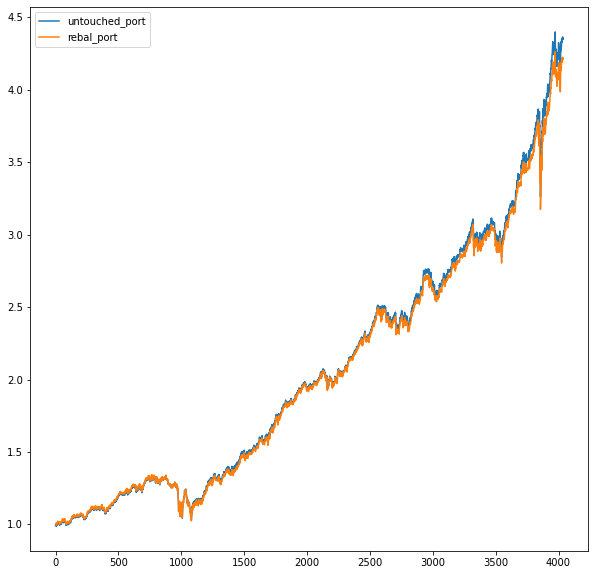

In [30]:
df_port_ret.plot(figsize = (10,10))

In [153]:
df_port_ret

,untouched_port,rebal_port
0,0.992151,0.992151
1,0.996962,1.004849
2,0.997773,1.000814
3,0.999624,1.001855
4,0.997124,0.997499
...,...,...
4030,4.344175,0.999195
4031,4.355223,1.002543
4032,4.346297,0.997951
4033,4.364811,1.004260


In [64]:
portfolio_sum

,total_value,asset_value,cash,cash_pct
date,,,,
2004-11-19,1.000000e+06,9.999624e+05,37.580841,0.000038
2004-11-22,1.004849e+06,1.004811e+06,37.580841,0.000037
2004-11-23,1.005667e+06,1.005630e+06,37.580841,0.000037
2004-11-24,1.007529e+06,1.007492e+06,37.580841,0.000037
2004-11-26,1.005011e+06,1.004973e+06,37.580841,0.000037
...,...,...,...,...
2020-11-23,3.701369e+06,3.684735e+06,16634.075369,0.004494
2020-11-24,3.716932e+06,3.700298e+06,16634.075369,0.004475
2020-11-25,3.709781e+06,3.693147e+06,16634.075369,0.004484


In [155]:
df_trades

ticker                      SPY                                        \
metric                  shr chg         prc       csh chg     tot shr   
2004-11-19           42582183.0  117.419998 -5.000000e+09  42582183.0   
2004-12-01 00:00:00         0.0  119.230003  0.000000e+00  42582183.0   
2004-12-17 00:00:00    202461.0  119.440002 -2.418194e+07  42784644.0   
2004-12-31 00:00:00         0.0  120.870003  0.000000e+00  42784644.0   
2005-02-01 00:00:00         0.0  118.910004  0.000000e+00  42784644.0   
...                         ...         ...           ...         ...   
2020-08-03 00:00:00         0.0  328.790009  0.000000e+00  58410485.0   
2020-09-01 00:00:00         0.0  352.600006  0.000000e+00  58410485.0   
2020-09-18 00:00:00    236578.0  330.649994 -7.822451e+07  58647063.0   
2020-10-01 00:00:00         0.0  337.040009  0.000000e+00  58647063.0   
2020-11-02 00:00:00         0.0  330.200012  0.000000e+00  58647063.0   

ticker                                                      TLT              \
metric                    tot bal divflag rebalflag     shr chg         prc   
2004-11-19           5.000000e+09     0.0       0.0  45320643.0   88.260002   
2004-12-01 00:00:00  5.077074e+09     0.0       0.0    185886.0   86.449997   
2004-12-17 00:00:00  5.110198e+09     1.0       0.0         0.0   88.750000   
2004-12-31 00:00:00  5.171380e+09     0.0       0.0    172204.0   88.550003   
2005-02-01 00:00:00  5.087522e+09     0.0       0.0    172562.0   91.220001   
...                           ...     ...       ...         ...         ...   
2020-08-03 00:00:00  1.920478e+10     0.0       0.0     85704.0  169.949997   
2020-09-01 00:00:00  2.059554e+10     0.0       0.0     85610.0  163.860001   
2020-09-18 00:00:00  1.939165e+10     1.0       0.0         0.0  163.570007   
2020-10-01 00:00:00  1.976641e+10     0.0       0.0     79454.0  163.360001   
2020-11-02 00:00:00  1.936526e+10     0.0       0.0     82123.0  158.580002   

ticker                             ...                                  \
metric                    csh chg  ...       tot bal divflag rebalflag   
2004-11-19          -4.000000e+09  ...  4.000000e+09     0.0       0.0   
2004-12-01 00:00:00 -1.606984e+07  ...  3.934039e+09     1.0       0.0   
2004-12-17 00:00:00  0.000000e+00  ...  4.038704e+09     0.0       0.0   
2004-12-31 00:00:00 -1.524866e+07  ...  4.044852e+09     1.0       0.0   
2005-02-01 00:00:00 -1.574111e+07  ...  4.182555e+09     1.0       0.0   
...                           ...  ...           ...     ...       ...   
2020-08-03 00:00:00 -1.456539e+07  ...  1.303345e+10     1.0       0.0   
2020-09-01 00:00:00 -1.402805e+07  ...  1.258043e+10     1.0       0.0   
2020-09-18 00:00:00  0.000000e+00  ...  1.255817e+10     0.0       0.0   
2020-10-01 00:00:00 -1.297961e+07  ...  1.255503e+10     1.0       0.0   
2020-11-02 00:00:00 -1.302307e+07  ...  1.220068e+10     1.0       0.0   

ticker                      GLD                                        \
metric                  shr chg         prc       csh chg     tot shr   
2004-11-19           22331400.0   44.779999 -1.000000e+09  22331400.0   
2004-12-01 00:00:00         0.0   45.380001  0.000000e+00  22331400.0   
2004-12-17 00:00:00         0.0   44.189999  0.000000e+00  22331400.0   
2004-12-31 00:00:00         0.0   43.799999  0.000000e+00  22331400.0   
2005-02-01 00:00:00         0.0   42.099998  0.000000e+00  22331400.0   
...                         ...         ...           ...         ...   
2020-08-03 00:00:00         0.0  185.639999  0.000000e+00  22331400.0   
2020-09-01 00:00:00         0.0  185.050003  0.000000e+00  22331400.0   
2020-09-18 00:00:00         0.0  183.199997  0.000000e+00  22331400.0   
2020-10-01 00:00:00         0.0  178.699997  0.000000e+00  22331400.0   
2020-11-02 00:00:00         0.0  177.910004  0.000000e+00  22331400.0   

ticker                                               
metric                    tot bal divflag rebalflag  
2

In [156]:
df_trades[df_trades.TLT.rebalflag == 1]

Empty DataFrame
Columns: [(SPY, shr chg), (SPY, prc), (SPY, csh chg), (SPY, tot shr), (SPY, tot bal), (SPY, divflag), (SPY, rebalflag), (TLT, shr chg), (TLT, prc), (TLT, csh chg), (TLT, tot shr), (TLT, tot bal), (TLT, divflag), (TLT, rebalflag), (GLD, shr chg), (GLD, prc), (GLD, csh chg), (GLD, tot shr), (GLD, tot bal), (GLD, divflag), (GLD, rebalflag)]
Index: []

[0 rows x 21 columns]

In [161]:
portfolio_detail

ticker             SPY                                                \
metric           price    return    weight      shares         value   
date                                                                   
2004-11-19  117.419998  0.988883  0.500000  42582183.0  5.000000e+09   
2004-11-22  117.980003  1.004769  0.499960  42582183.0  5.023846e+09   
2004-11-23  118.160004  1.001526  0.500316  42582183.0  5.031511e+09   
2004-11-24  118.440002  1.002370  0.500574  42582183.0  5.043434e+09   
2004-11-26  118.339996  0.999156  0.501405  42582183.0  5.039175e+09   
...                ...       ...       ...         ...           ...   
2020-11-23  357.459991  1.005994  0.563862  58647063.0  2.096398e+10   
2020-11-24  363.220001  1.016114  0.570557  58647063.0  2.130179e+10   
2020-11-25  362.660004  0.998458  0.570784  58647063.0  2.126894e+10   
2020-11-27  363.670013  1.002785  0.570241  58647063.0  2.132818e+10   
2020-11-30  362.059998  0.995573  0.569771  58647063.0  2.123376e+10   

ticker             TLT                                                \
metric           price    return    weight      shares         value   
date                                                                   
2004-11-19   88.260002  0.992020  0.400000  45320643.0  4.000000e+09   
2004-11-22   88.720001  1.005212  0.400144  45320643.0  4.020848e+09   
2004-11-23   88.830002  1.001240  0.400315  45320643.0  4.025833e+09   
2004-11-24   88.830002  1.000000  0.399575  45320643.0  4.025833e+09   
2004-11-26   88.250000  0.993471  0.397960  45320643.0  3.999547e+09   
...                ...       ...       ...         ...           ...   
2020-11-23  160.770004  0.995418  0.332690  76937084.0  1.236918e+10   
2020-11-24  159.169998  0.990048  0.328005  76937084.0  1.224608e+10   
2020-11-25  158.679993  0.996921  0.327630  76937084.0  1.220838e+10   
2020-11-27  160.220001  1.009705  0.329577  76937084.0  1.232686e+10   
2020-11-30  160.020004  0.998752  0.330357  76937084.0  1.231147e+10   

ticker             GLD                                                
metric           price    return    weight      shares         value  
date                                                                  
2004-11-19   44.779999  1.009013  0.100000  22331400.0  1.000000e+09  
2004-11-22   44.950001  1.003796  0.099895  22331400.0  1.003796e+09  
2004-11-23   44.750000  0.995551  0.099370  22331400.0  9.993302e+08  
2004-11-24   45.049999  1.006704  0.099851  22331400.0  1.006030e+09  
2004-11-26   45.290001  1.005327  0.100635  22331400.0  1.011389e+09  
...                ...       ...       ...         ...           ...  
2020-11-23  172.229996  0.980306  0.103448  22331400.0  3.846137e+09  
2020-11-24  169.589996  0.984672  0.101438  22331400.0  3.787182e+09  
2020-11-25  169.509995  0.999528  0.101587  22331400.0  3.785395e+09  
2020-11-27  167.789993  0.989853  0.100181  22331400.0  3.746985e+09  
2020-11-30  166.669998  0.993325  0.099873  22331400.0  3.721974e+09  

[4035 rows x 15 columns]

In [55]:
15666.33*3.7

57965.421

In [60]:
portfolio_sum.total_value[-1]+15666.33*3.72/2

3734206.3086544047